<b><h1><center>DenseNet201+RESNET101</center></h1></b>

In [1]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [2]:
INIT_LR = 5e-4
EPOCHS = 32
BS = 2
tta_times = 10
imgSize = 768

# SHOW ORIGINAL IMAGES

In [3]:
def show_original_img(category):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    train_path = '../input/covid19-radiography-database/COVID-19 Radiography Database/'
    ten_random_samples = pd.Series(os.listdir(os.path.join(train_path, category))).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(train_path, category, image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

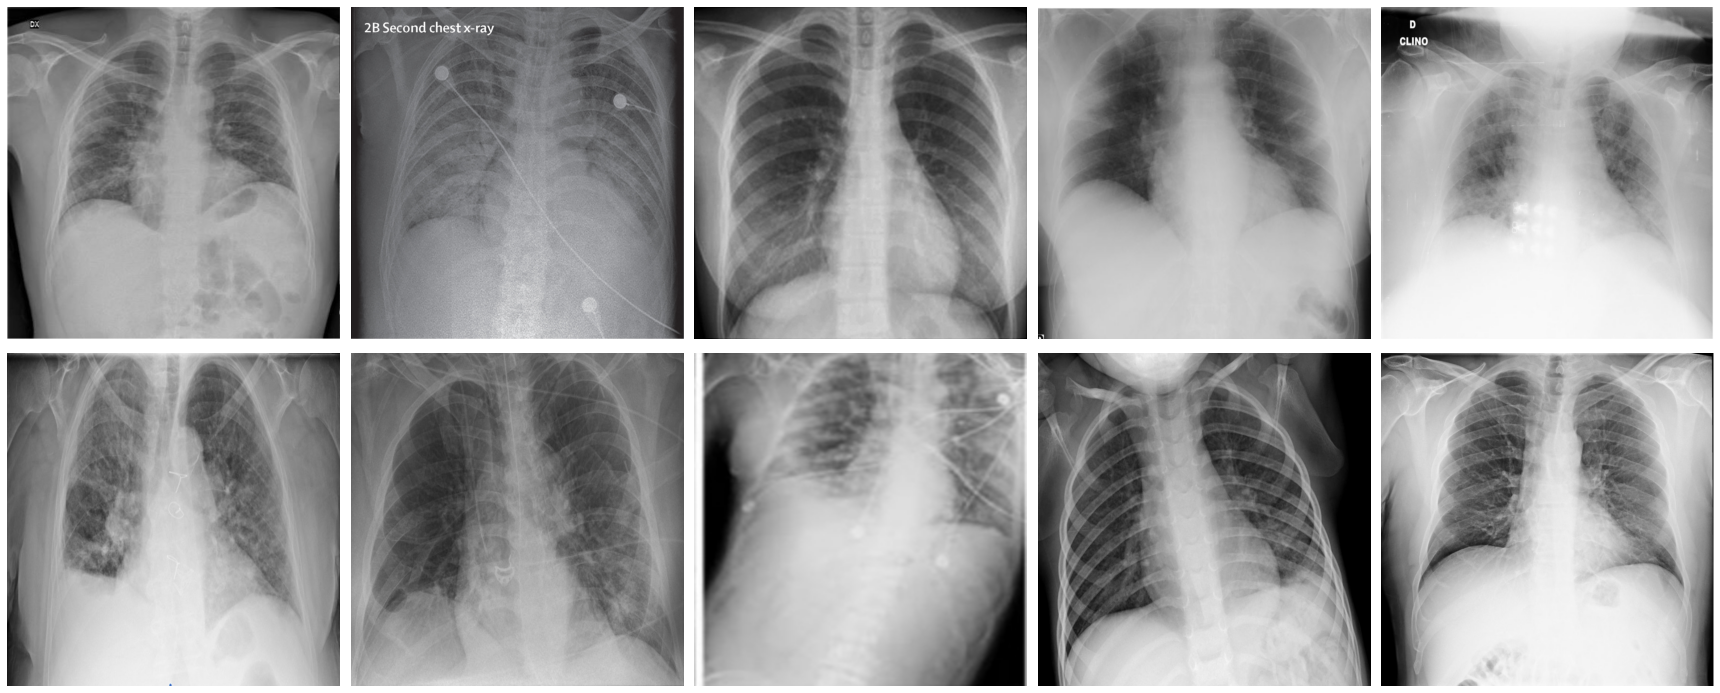

In [4]:
show_original_img('COVID-19')

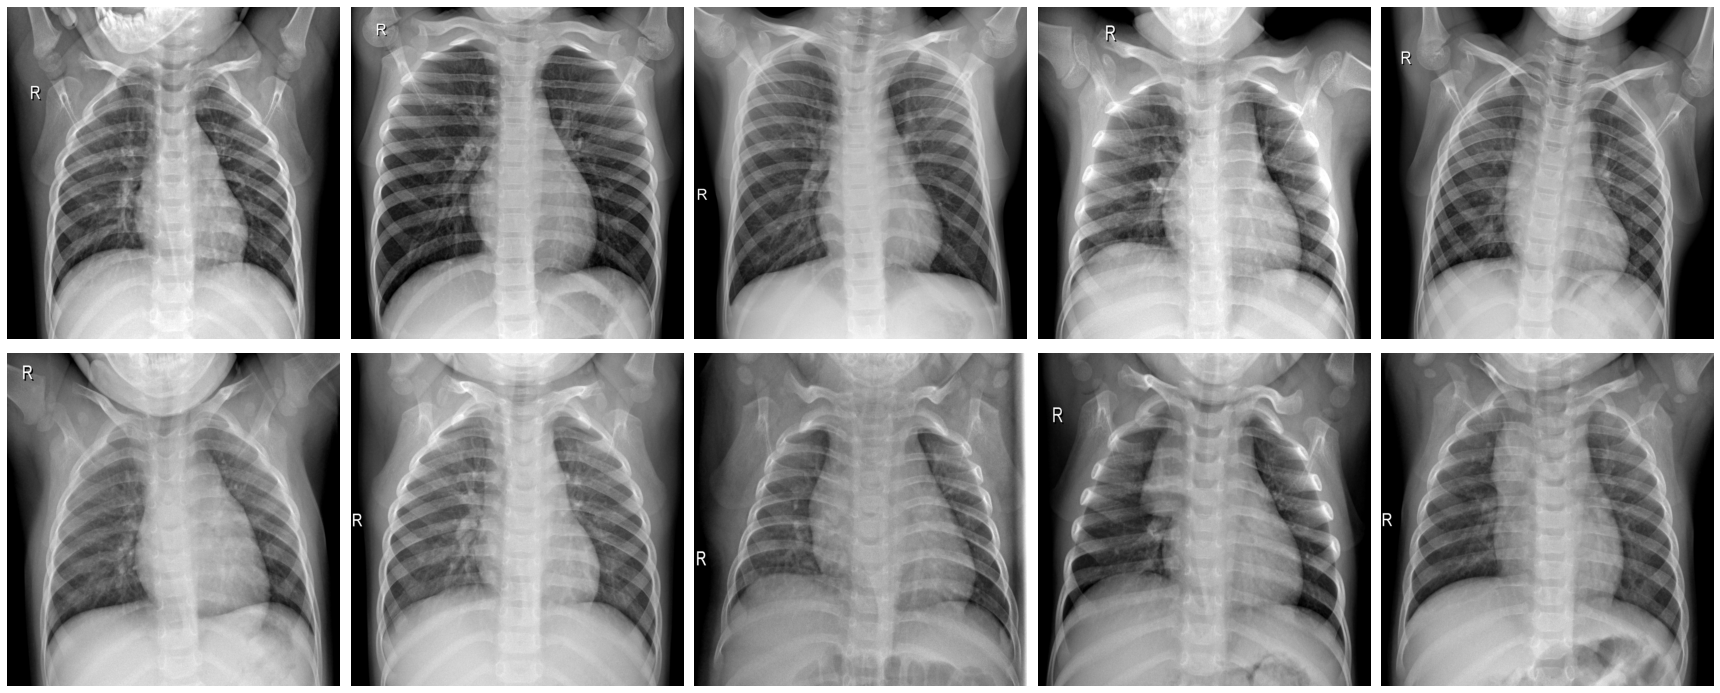

In [5]:
show_original_img('NORMAL')

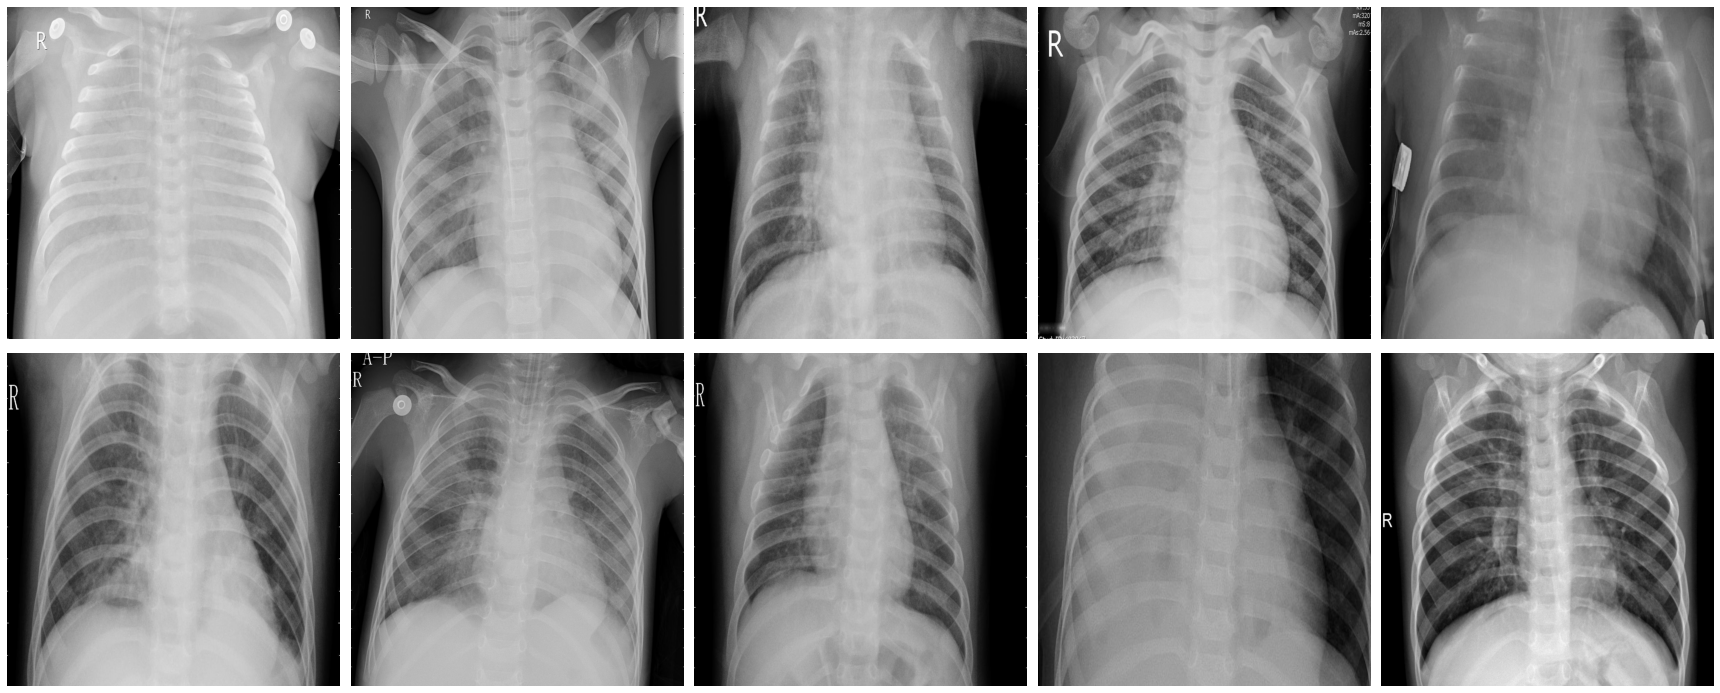

In [6]:
show_original_img('Viral Pneumonia')

We can see that images in the "NORMAL" and "Viral pneumonia" folders always have the letter 'R', raise up both hands and include the lower jawbone.

# IMAGE PREPROCESSING

In [7]:
imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [8]:
os.makedirs('dataset/COVID-19')
os.makedirs('dataset/NORMAL')
os.makedirs('dataset/Viral Pneumonia')

In [9]:
for imagePath in tqdm(imagePaths):
    image = cv2.imread(imagePath)
    image = image[128:1024-128, 128:1024-128]
    cv2.imwrite('dataset/'+'/'.join(imagePath.split(os.path.sep)[-2:]), image)

100%|██████████| 2905/2905 [02:08<00:00, 22.69it/s]


# SHOW CROPPED IMAGES

In [10]:
def show_cropped_img(category):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    train_path = 'dataset/'
    ten_random_samples = pd.Series(os.listdir(os.path.join(train_path, category))).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(train_path, category, image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

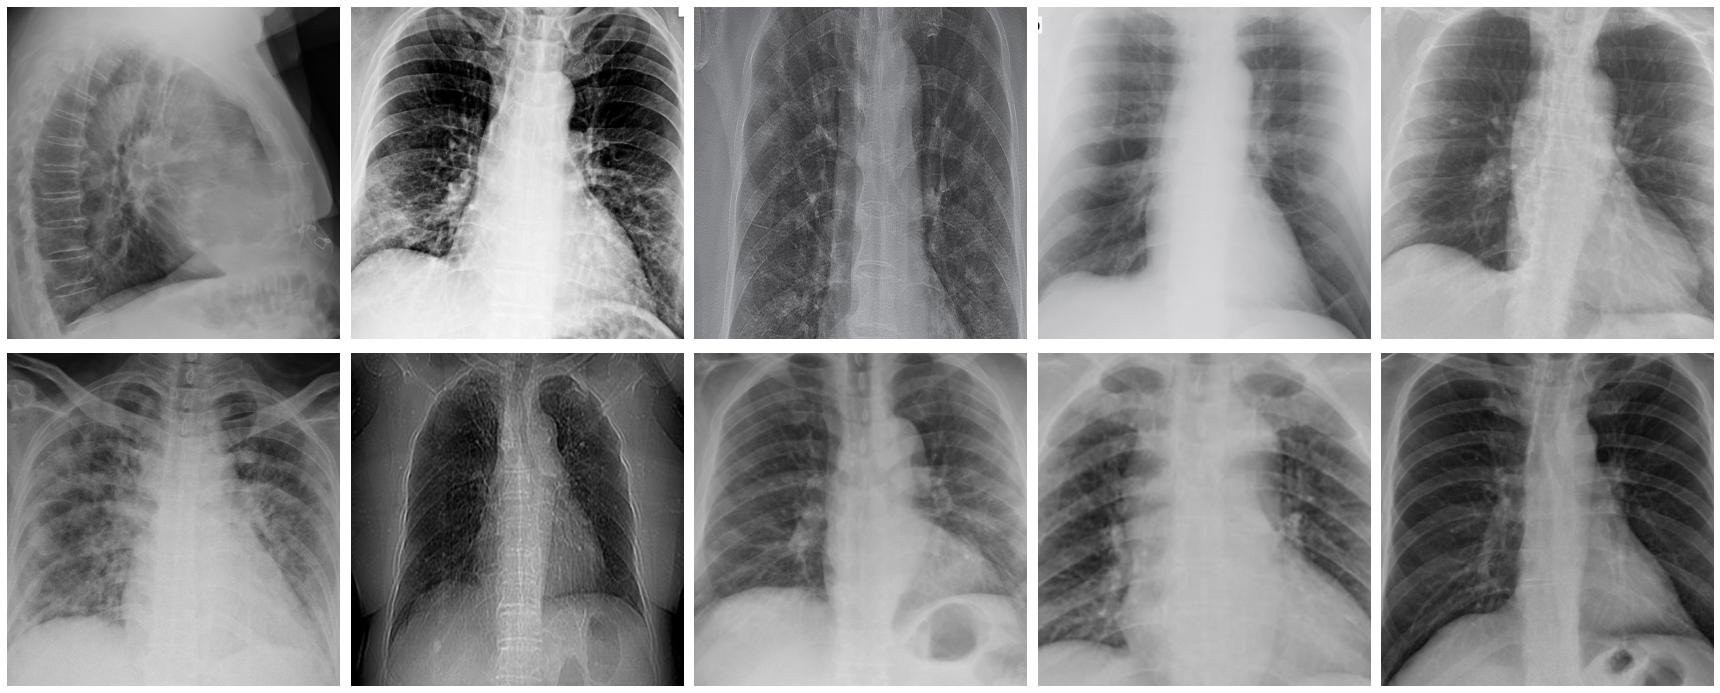

In [11]:
show_cropped_img('COVID-19')

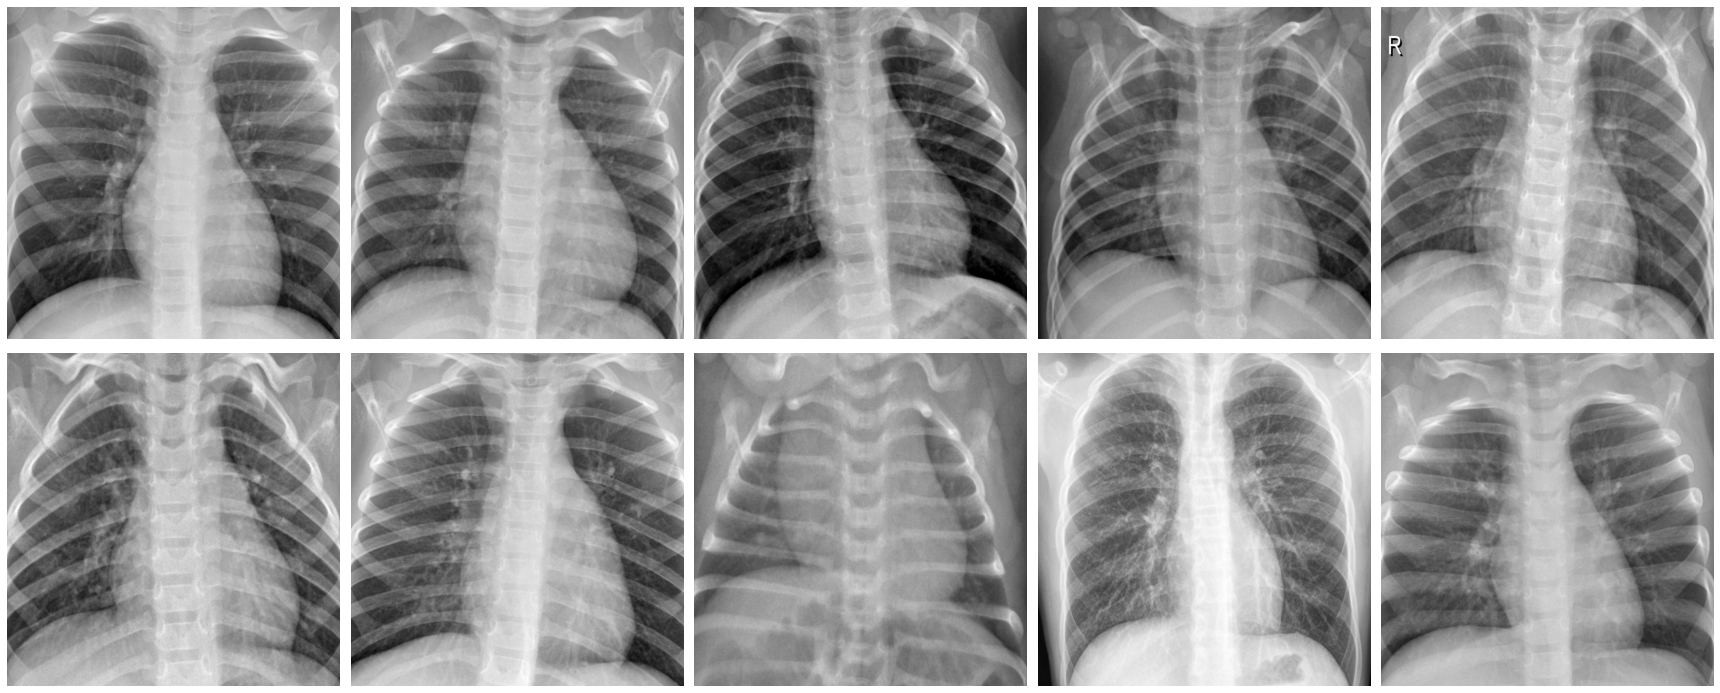

In [12]:
show_cropped_img('NORMAL')

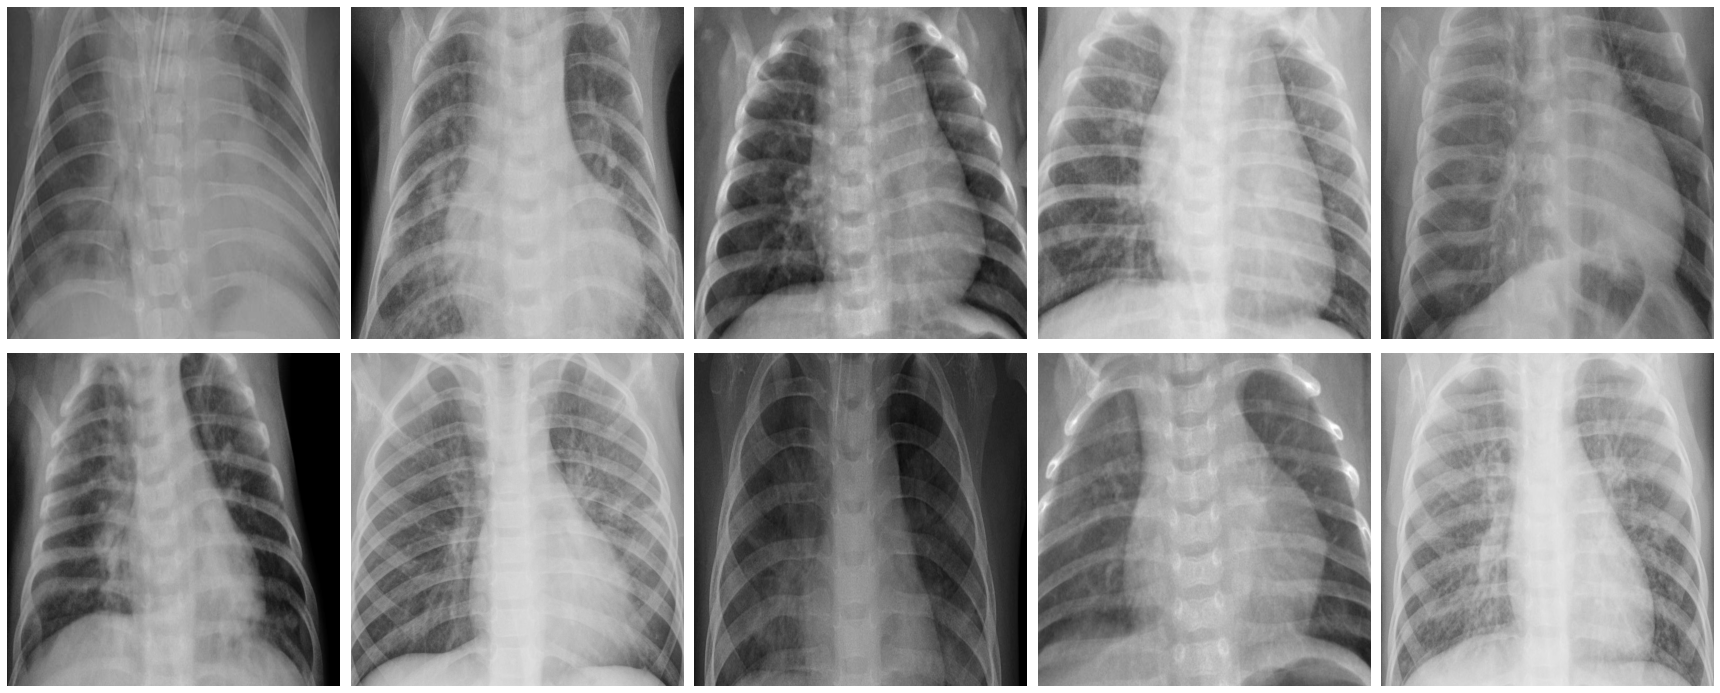

In [13]:
show_cropped_img('Viral Pneumonia')

# LOAD

In [14]:
def change_brightness(img):
    value = random.randint(-10,10)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def preprocessing(img):
    img = change_brightness(img)
    return img

In [15]:
trainAug = ImageDataGenerator(rotation_range=20, 
                              horizontal_flip = True,
                              shear_range=0.1,
                              zoom_range=0.1,
                              channel_shift_range = 0.05,
                              fill_mode="nearest", 
                              rescale=1./255,
                              preprocessing_function = preprocessing,
                              validation_split=0.2)
testAug = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)

In [16]:
train_generator = trainAug.flow_from_directory('dataset/',
                                               target_size=(imgSize, imgSize),
                                               batch_size=BS,
                                               class_mode='categorical', 
                                               subset='training')

Found 2325 images belonging to 3 classes.


In [17]:
test_generator = testAug.flow_from_directory('dataset/',
                                              target_size=(imgSize, imgSize),
                                              batch_size=BS,
                                              class_mode='categorical', 
                                              subset='validation')

Found 580 images belonging to 3 classes.


# MODEL

In [18]:
def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn', x[0], x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

def build_model():
    input_tensor = Input(shape=(imgSize, imgSize, 3))
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    model1 = DenseNet201(weights='imagenet', include_top=False, input_tensor=input_tensor,input_shape=(imgSize, imgSize, 3))
    model2 = ResNet101(weights='imagenet', include_top=False, input_tensor=input_tensor,input_shape=(imgSize, imgSize, 3))    
    
    for layer in model1.layers:
        layer._name = 'model1_' + layer.name

    last_layer1 = model1.get_layer('model1_bn')
    last_output1 = last_layer1.output

    for layer in model2.layers:
        layer._name = 'model2_' + layer.name

    last_layer2 = model2.get_layer('model2_conv5_block3_3_bn')
    last_output2 = last_layer2.output
    
    
    model1_ = Model(inputs=model1.input, outputs=last_output1)
    model2_ = Model(inputs=model2.input, outputs=last_output2)
    
    model1_.trainable = True
    model2_.trainable = True
    
    model1_.compile('adam',loss="categorical_crossentropy", metrics=["accuracy"])
    model2_.compile('adam',loss="categorical_crossentropy", metrics=["accuracy"])
    
    d1 = model1_.output
    d2 = model2_.output

    bilinear = Lambda(outer_product, name='outer_product1')([d1,d2])
    headmodel = Flatten(name="flatten")(bilinear)
    headmodel = Dense(64, activation="relu")(headmodel)
    predictions=Dense(3, activation='softmax', name='predictions')(headmodel)
    model = Model(inputs=model1.input, outputs=predictions)
    return model

In [19]:
model = build_model()
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

171450368/171446536 [==============================] - 2s 0us/step


In [20]:
best_val_acc = 0
best_val_loss = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    val_loss = logs['val_loss']
    global best_val_acc
    global best_val_loss

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        model.save('model.h5')
    elif val_acc == best_val_acc:
        if val_loss > best_val_loss:
            best_val_loss= val_loss
            model.save('model.h5')

In [21]:
H = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BS,
#    callbacks= [LambdaCallback(on_epoch_end=saveModel),
#              EarlyStopping(monitor='val_accuracy', patience=3),
#              ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=2),
#              ],
    epochs=EPOCHS)

Epoch 1/32
1162/1162 [==============================] - 791s 681ms/step - loss: 0.8541 - accuracy: 0.6362 - val_loss: 0.9352 - val_accuracy: 0.4879
Epoch 2/32
1162/1162 [==============================] - 781s 672ms/step - loss: 0.7730 - accuracy: 0.6672 - val_loss: 1.3089 - val_accuracy: 0.3172
Epoch 3/32
1162/1162 [==============================] - 780s 671ms/step - loss: 0.7256 - accuracy: 0.6793 - val_loss: 1.5481 - val_accuracy: 0.4638
Epoch 4/32
1162/1162 [==============================] - 779s 670ms/step - loss: 0.6690 - accuracy: 0.7193 - val_loss: 6.8807 - val_accuracy: 0.0759
Epoch 5/32
1162/1162 [==============================] - 779s 671ms/step - loss: 0.5601 - accuracy: 0.7800 - val_loss: 1.1619 - val_accuracy: 0.4672
Epoch 6/32
1162/1162 [==============================] - 780s 672ms/step - loss: 0.5209 - accuracy: 0.7869 - val_loss: 1.6887 - val_accuracy: 0.1845
Epoch 7/32
1162/1162 [==============================] - 780s 671ms/step - loss: 0.4489 - accuracy: 0.8196 - val_

# PLOT

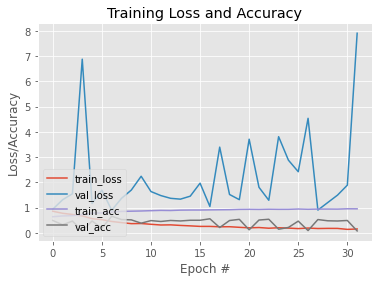

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# TEST WITH TTA

In [23]:
def wrong_to_list(preds, generator):
    res = []
    for i in range(len(preds)):
        if (preds[i] != generator.labels[i]):
            res.append(generator.filenames[i])
    return res

def show_wrong_img(l):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    ten_random_samples = pd.Series(l).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join('dataset/', image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

## ON TRAIN

In [24]:
train = ImageDataGenerator(rescale=1./255,
                           validation_split=0.2).flow_from_directory('dataset/',
                                                                     target_size=(imgSize, imgSize),
                                                                     batch_size=BS,
                                                                     class_mode='categorical',
                                                                     shuffle = False,
                                                                     subset='training')

Found 2325 images belonging to 3 classes.


In [25]:
CName = {v: k for k, v in train.class_indices.items()}
predIdxs = model.predict_generator(train)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(train.labels, predIdxs, target_names=list(train.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    0.07570   1.00000   0.14074       176
         NORMAL    0.00000   0.00000   0.00000      1073
Viral Pneumonia    0.00000   0.00000   0.00000      1076

       accuracy                        0.07570      2325
      macro avg    0.02523   0.33333   0.04691      2325
   weighted avg    0.00573   0.07570   0.01065      2325



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != train.labels[i]):
        print('Filename:',train.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(train.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]])

Filename: NORMAL (124).png 		PRED: COVID-19
Filename: NORMAL (1240).png 		PRED: COVID-19
Filename: NORMAL (1241).png 		PRED: COVID-19
Filename: NORMAL (1242).png 		PRED: COVID-19
Filename: NORMAL (1243).png 		PRED: COVID-19
Filename: NORMAL (1244).png 		PRED: COVID-19
Filename: NORMAL (1245).png 		PRED: COVID-19
Filename: NORMAL (1246).png 		PRED: COVID-19
Filename: NORMAL (1247).png 		PRED: COVID-19
Filename: NORMAL (1248).png 		PRED: COVID-19
Filename: NORMAL (1249).png 		PRED: COVID-19
Filename: NORMAL (125).png 		PRED: COVID-19
Filename: NORMAL (1250).png 		PRED: COVID-19
Filename: NORMAL (1251).png 		PRED: COVID-19
Filename: NORMAL (1252).png 		PRED: COVID-19
Filename: NORMAL (1253).png 		PRED: COVID-19
Filename: NORMAL (1254).png 		PRED: COVID-19
Filename: NORMAL (1255).png 		PRED: COVID-19
Filename: NORMAL (1256).png 		PRED: COVID-19
Filename: NORMAL (1257).png 		PRED: COVID-19
Filename: NORMAL (1258).png 		PRED: COVID-19
Filename: NORMAL (1259).png 		PRED: COVID-19
Filename: NO

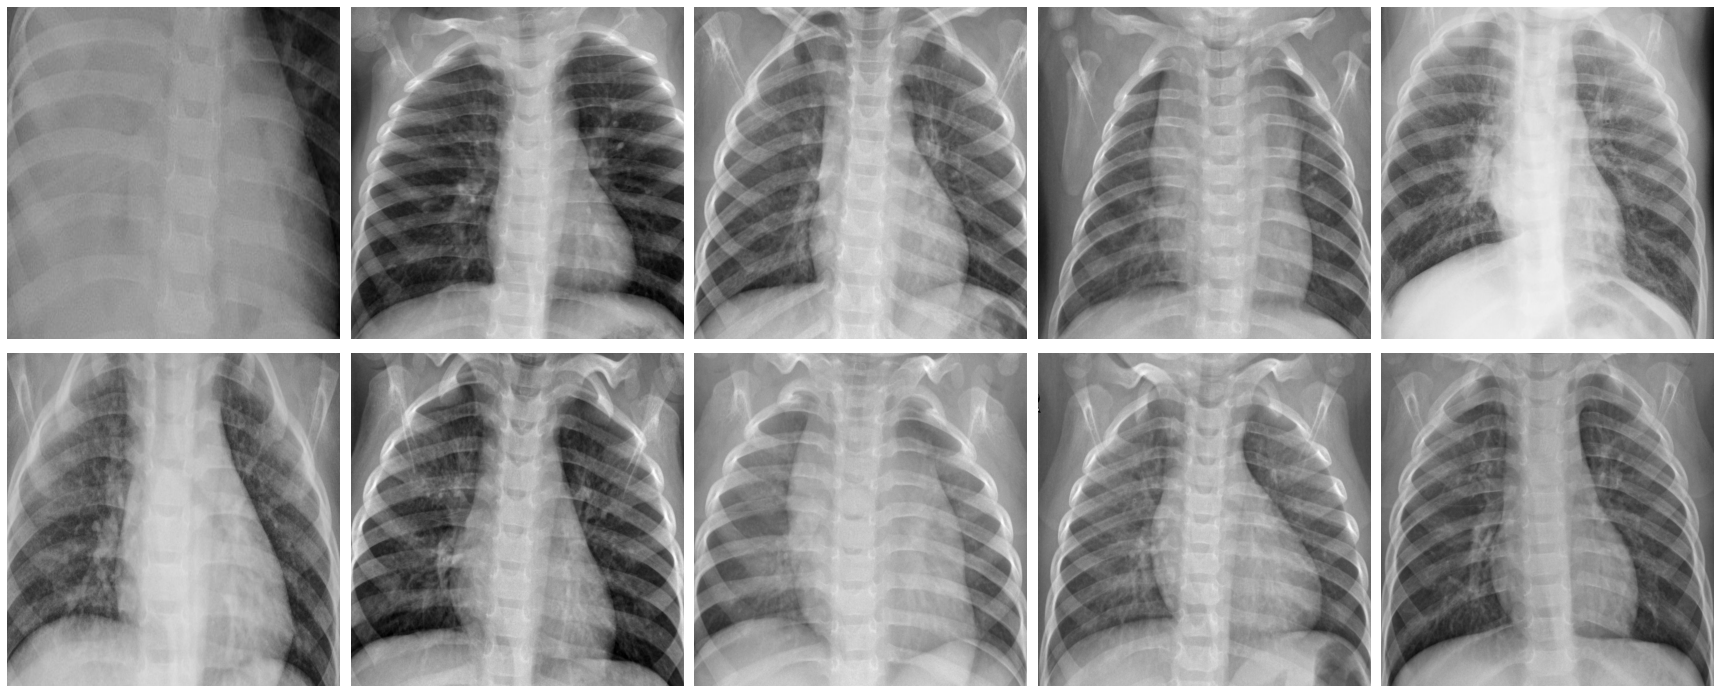

In [27]:
show_wrong_img(wrong_to_list(predIdxs, train))

## ON TEST

In [28]:
test = ImageDataGenerator(rescale=1./255, 
                          validation_split=0.2).flow_from_directory('dataset/',
                                                                    target_size=(imgSize, imgSize),
                                                                    batch_size=BS,
                                                                    class_mode='categorical', 
                                                                    shuffle = False, 
                                                                    subset='validation')

Found 580 images belonging to 3 classes.


In [29]:
CName = {v: k for k, v in test.class_indices.items()}
predIdxs = model.predict_generator(test, verbose=1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test.labels, predIdxs, target_names=list(test.class_indices.keys()), digits = 5))

290/290 [==============================] - 68s 233ms/step
                 precision    recall  f1-score   support

       COVID-19    0.07414   1.00000   0.13804        43
         NORMAL    0.00000   0.00000   0.00000       268
Viral Pneumonia    0.00000   0.00000   0.00000       269

       accuracy                        0.07414       580
      macro avg    0.02471   0.33333   0.04601       580
   weighted avg    0.00550   0.07414   0.01023       580



In [30]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != test.labels[i]):
        print('Filename:',test.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(test.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]])

Filename: NORMAL (1).png 		PRED: COVID-19
Filename: NORMAL (10).png 		PRED: COVID-19
Filename: NORMAL (100).png 		PRED: COVID-19
Filename: NORMAL (1000).png 		PRED: COVID-19
Filename: NORMAL (1001).png 		PRED: COVID-19
Filename: NORMAL (1002).png 		PRED: COVID-19
Filename: NORMAL (1003).png 		PRED: COVID-19
Filename: NORMAL (1004).png 		PRED: COVID-19
Filename: NORMAL (1005).png 		PRED: COVID-19
Filename: NORMAL (1006).png 		PRED: COVID-19
Filename: NORMAL (1007).png 		PRED: COVID-19
Filename: NORMAL (1008).png 		PRED: COVID-19
Filename: NORMAL (1009).png 		PRED: COVID-19
Filename: NORMAL (101).png 		PRED: COVID-19
Filename: NORMAL (1010).png 		PRED: COVID-19
Filename: NORMAL (1011).png 		PRED: COVID-19
Filename: NORMAL (1012).png 		PRED: COVID-19
Filename: NORMAL (1013).png 		PRED: COVID-19
Filename: NORMAL (1014).png 		PRED: COVID-19
Filename: NORMAL (1015).png 		PRED: COVID-19
Filename: NORMAL (1016).png 		PRED: COVID-19
Filename: NORMAL (1017).png 		PRED: COVID-19
Filename: NORMAL 

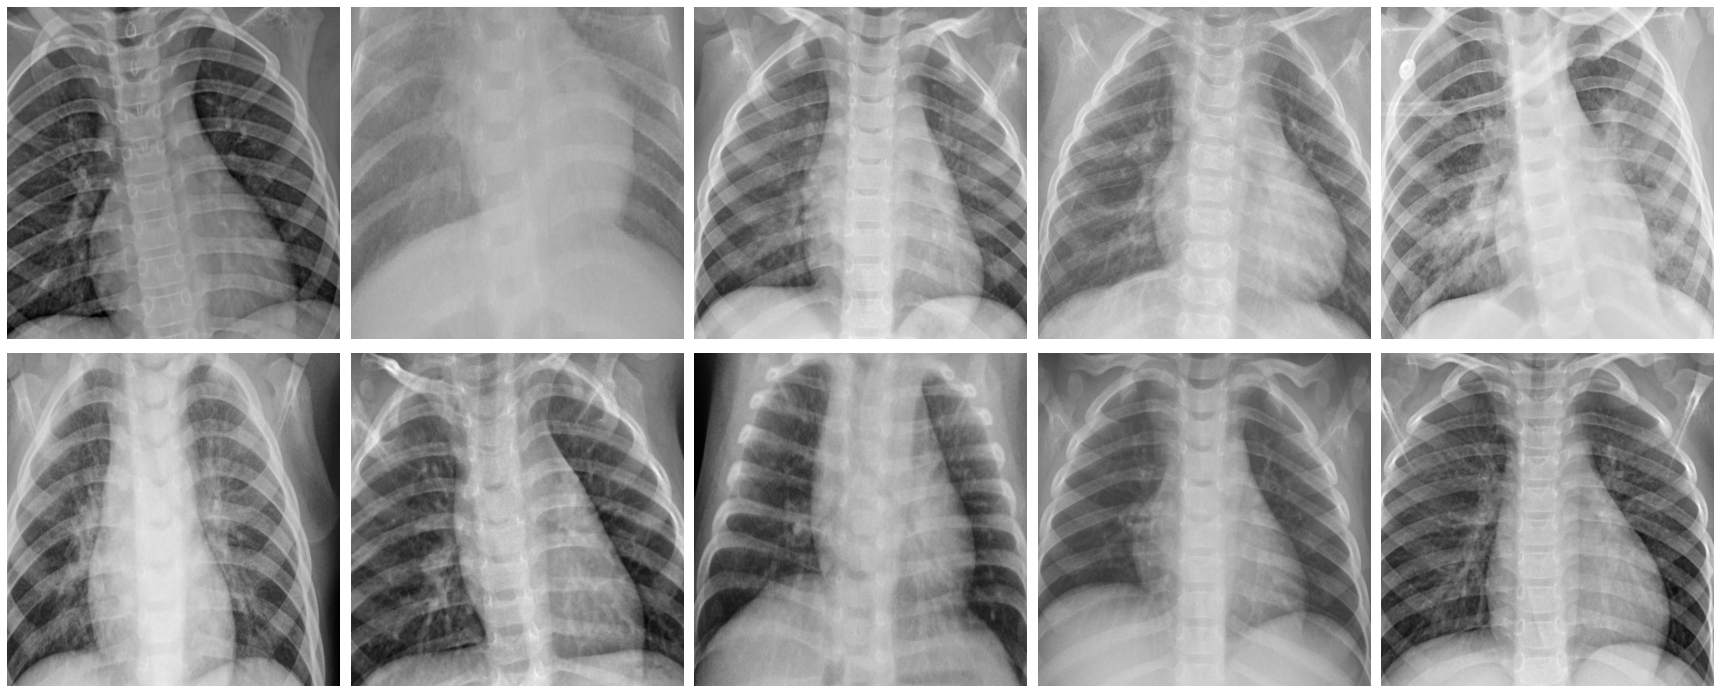

In [31]:
show_wrong_img(wrong_to_list(predIdxs, test))

# TEST WITH TTA

## ON TRAIN

train = ImageDataGenerator(rotation_range=5, 
                          horizontal_flip = True,
                          shear_range=0.05,
                          zoom_range=0.05,
                          channel_shift_range = 0.025,
                          fill_mode="nearest", 
                          rescale=1./255,
                          preprocessing_function = preprocessing,
                          validation_split=0.2).flow_from_directory('dataset/',
                                                                     target_size=(imgSize, imgSize),
                                                                     batch_size=BS,
                                                                     class_mode='categorical',
                                                                     shuffle = False,
                                                                     subset='training')
CName = {v: k for k, v in train.class_indices.items()}
probabilities = []
for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(train, verbose=1))
predIdxs = np.mean(probabilities, axis=0)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(train.labels, predIdxs, target_names=list(train.class_indices.keys()), digits = 5))

for i in range(len(predIdxs)):
    if (predIdxs[i] != train.labels[i]):
        print('Filename:',train.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(train.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]])

show_wrong_img(wrong_to_list(predIdxs, train))

## ON TEST

test = ImageDataGenerator(rotation_range=5, 
                          horizontal_flip = True,
                          shear_range=0.05,
                          zoom_range=0.05,
                          channel_shift_range = 0.025,
                          fill_mode="nearest",
                          rescale=1./255,
                          preprocessing_function = preprocessing,
                          validation_split=0.2).flow_from_directory('dataset/',
                                                                    target_size=(imgSize, imgSize),
                                                                    batch_size=BS,
                                                                    class_mode='categorical', 
                                                                    shuffle = False, 
                                                                    subset='validation')
CName = {v: k for k, v in test.class_indices.items()}
probabilities = []
for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(test, verbose=1))
predIdxs = np.mean(probabilities, axis=0)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(test.labels, predIdxs, target_names=list(test.class_indices.keys()), digits = 5))

for i in range(len(predIdxs)):
    if (predIdxs[i] != test.labels[i]):
        print('Filename:',test.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(test.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]])

show_wrong_img(wrong_to_list(predIdxs, test))

plot_model(model,to_file="model_DenseNet201_VGG19.png", show_shapes=True, show_layer_names=True, expand_nested=False)